# House Property Sales - **Time Series Analysis**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import os
import zipfile

import PIL

from tensorflow.keras import Sequential, layers, optimizers, losses, callbacks

In [17]:
file = '/content/archive (19).zip'

ref = zipfile.ZipFile(file)
ref.extractall()
ref.close()

In [18]:
df = pd.read_csv('POP.csv')
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [19]:
df.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


We can drop the `realtime` columns and focus on the values and date of their recording. Also, we can modify the index to be the dates and this will be useful for turning the dataset into a more coherent time series set.

In [22]:
pop = df.drop('realtime_start', axis=1)
pop = pop.drop('realtime_end', axis=1)
pop.index = pd.to_datetime(pop.date)
pop

,value,date
date,,
1952-01-01,156309.000,1952-01-01
1952-02-01,156527.000,1952-02-01
1952-03-01,156731.000,1952-03-01
1952-04-01,156943.000,1952-04-01
1952-05-01,157140.000,1952-05-01
...,...,...
2019-08-01,329591.333,2019-08-01
2019-09-01,329785.872,2019-09-01
2019-10-01,329982.035,2019-10-01


In [23]:
pop = pop.drop('date', axis=1)
pop.head(20)

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0
1952-06-01,157343.0
1952-07-01,157553.0
1952-08-01,157798.0
1952-09-01,158053.0


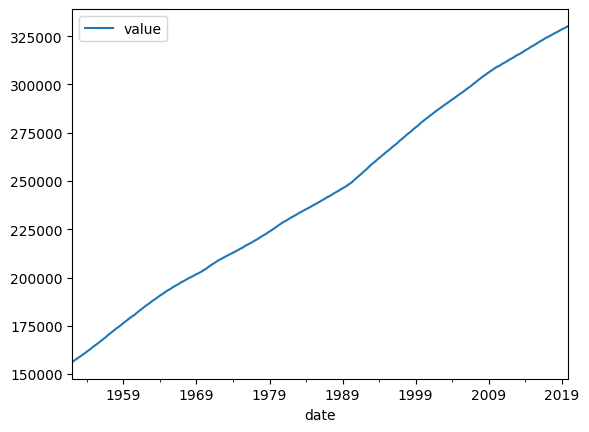

In [24]:
pop.plot();

Let's plot some subsets to look at the trend closer...

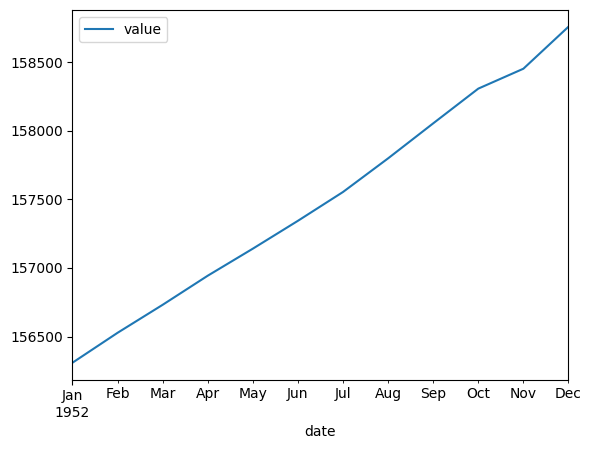

In [25]:
pop[:12].plot();

In [55]:
len(pop)

816

In [76]:
train_split = int(0.8 * len(pop))
val_split = int(0.9 * len(pop))


train_data = pop.value[:train_split]
val_data = pop.value[train_split:val_split]
test_data = pop.value[val_split:]

In [77]:
# Standardize datasets
train_mean = train_data.mean()
train_std = train_data.std()

val_mean = val_data.mean()
val_std = val_data.std()

test_mean = test_data.mean()
test_std = test_data.std()

In [78]:
train_data = (train_data - train_mean) / train_std
val_data = (val_data - val_mean) / val_std
test_data = (test_data - test_mean) / test_std

In [79]:
WINDOW = 6

def make_windows(data, window=WINDOW):

  sequences = []
  labels = []

  for i in range(len(data) - window):
    row = [v for v in data[i:i + window]]
    sequences.append(row)
    label = data[i + window]
    labels.append(label)

  return np.array(sequences), np.array(labels)

In [80]:
# Create windowed datasets
X_train, y_train = make_windows(train_data)
X_val, y_val = make_windows(val_data)
X_test, y_test = make_windows(test_data)

In [81]:
X_train[:6], y_train[:6]

(array([[-1.76067126, -1.75515167, -1.74998655, -1.74461888, -1.739631  ,
         -1.7344912 ],
        [-1.75515167, -1.74998655, -1.74461888, -1.739631  , -1.7344912 ,
         -1.72917417],
        [-1.74998655, -1.74461888, -1.739631  , -1.7344912 , -1.72917417,
         -1.72297097],
        [-1.74461888, -1.739631  , -1.7344912 , -1.72917417, -1.72297097,
         -1.71651457],
        [-1.739631  , -1.7344912 , -1.72917417, -1.72297097, -1.71651457,
         -1.71010881],
        [-1.7344912 , -1.72917417, -1.72297097, -1.71651457, -1.71010881,
         -1.70643753]]),
 array([-1.72917417, -1.72297097, -1.71651457, -1.71010881, -1.70643753,
        -1.69868985]))

In [82]:
X_val[:6], y_val[:6]

(array([[-1.83990682, -1.79086581, -1.7389994 , -1.68511484, -1.62638672,
         -1.56967674],
        [-1.79086581, -1.7389994 , -1.68511484, -1.62638672, -1.56967674,
         -1.5174067 ],
        [-1.7389994 , -1.68511484, -1.62638672, -1.56967674, -1.5174067 ,
         -1.46776025],
        [-1.68511484, -1.62638672, -1.56967674, -1.5174067 , -1.46776025,
         -1.42053557],
        [-1.62638672, -1.56967674, -1.5174067 , -1.46776025, -1.42053557,
         -1.37452179],
        [-1.56967674, -1.5174067 , -1.46776025, -1.42053557, -1.37452179,
         -1.33032434]]),
 array([-1.5174067 , -1.46776025, -1.42053557, -1.37452179, -1.33032434,
        -1.28330148]))

In [83]:
# Build metrics pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def evaluate_model(y_true, y_pred):
 mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy()
 mse = tf.keras.metrics.mean_squared_error(y_true, y_pred).numpy()
 rmse = np.sqrt(mse)
 mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy()

 eval_dict = {'mae': mae,
              'mse': mse,
              'rmse':rmse,
              'mape': mape}
            
 return eval_dict

In [84]:
# Create callbacks
early = callbacks.EarlyStopping(monitor='val_mae',
                                patience=10,
                                verbose=False,
                                restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae',
                                        patience=10,
                                        factor=0.1,
                                        verbose=False)

cp = callbacks.ModelCheckpoint(filepath='models/',
                               monitor='val_mae',
                               save_best_only=True)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 **((epoch)/100))

In [85]:
# Create model
cbs = [early, reduce_lr, cp, lr_scheduler]

model = Sequential([
    layers.Input((6, 1)),
    layers.LSTM(32, recurrent_dropout=0.1),
    layers.Dense(16),
    layers.Dense(1, 'linear')
], name='lstm-dense')

model.compile(loss=losses.mae,
              optimizer='adam',
              metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val),
          callbacks=cbs)

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.5858 - mae: 0.5858 - mse: 0.5260

21/21 [==============================] - 8s 244ms/step - loss: 0.5858 - mae: 0.5858 - mse: 0.5260 - val_loss: 0.1969 - val_mae: 0.1969 - val_mse: 0.0521 - lr: 0.0010
Epoch 2/100
20/21 [===========================>..] - ETA: 0s - loss: 0.0823 - mae: 0.0823 - mse: 0.0121

21/21 [==============================] - 3s 166ms/step - loss: 0.0819 - mae: 0.0819 - mse: 0.0121 - val_loss: 0.1070 - val_mae: 0.1070 - val_mse: 0.0135 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0450 - mae: 0.0450 - mse: 0.0039 - val_loss: 0.1214 - val_mae: 0.1214 - val_mse: 0.0165 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0346 - mae: 0.0346 - mse: 0.0026 - val_loss: 0.1194 - val_mae: 0.1194 - val_mse: 0.0155 - lr: 0.0011
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0255 - mae: 0.0255 - mse: 0.0012 - val_loss: 0.1124 - val_mae: 0.1124 - val_mse: 0.0133 - lr: 0.0011
Epoch 6/100
20/21 [===========================>..] - ETA: 0s - loss: 0.0218 - mae: 0.0218 - mse: 9.7494e-04

21/21 [==============================] - 3s 168ms/step - loss: 0.0220 - mae: 0.0220 - mse: 9.8612e-04 - val_loss: 0.1004 - val_mae: 0.1004 - val_mse: 0.0116 - lr: 0.0011
Epoch 7/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0188 - mae: 0.0188 - mse: 6.7801e-04 - val_loss: 0.1061 - val_mae: 0.1061 - val_mse: 0.0116 - lr: 0.0011
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0139 - mae: 0.0139 - mse: 3.8276e-04 - val_loss: 0.1064 - val_mae: 0.1064 - val_mse: 0.0117 - lr: 0.0012
Epoch 9/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0151 - mae: 0.0151 - mse: 4.3909e-04 - val_loss: 0.1213 - val_mae: 0.1213 - val_mse: 0.0153 - lr: 0.0012
Epoch 10/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0153 - mae: 0.0153 - mse: 4.5228e-04 - val_loss: 0.1149 - val_mae: 0.1149 - val_mse: 0.0147 - lr: 0.0012
Epoch 11/100
21/21 [==============================] - ETA: 0s - loss: 0.0144 - mae: 0.0144 - mse: 3.9073e-

21/21 [==============================] - 4s 207ms/step - loss: 0.0144 - mae: 0.0144 - mse: 3.9073e-04 - val_loss: 0.0985 - val_mae: 0.0985 - val_mse: 0.0100 - lr: 0.0013
Epoch 12/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0125 - mae: 0.0125 - mse: 3.0320e-04 - val_loss: 0.1114 - val_mae: 0.1114 - val_mse: 0.0129 - lr: 0.0013
Epoch 13/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0108 - mae: 0.0108 - mse: 2.2265e-04 - val_loss: 0.1159 - val_mae: 0.1159 - val_mse: 0.0142 - lr: 0.0013
Epoch 14/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0112 - mae: 0.0112 - mse: 2.6066e-04 - val_loss: 0.1046 - val_mae: 0.1046 - val_mse: 0.0115 - lr: 0.0013
Epoch 15/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0109 - mae: 0.0109 - mse: 2.3327e-04 - val_loss: 0.1145 - val_mae: 0.1145 - val_mse: 0.0138 - lr: 0.0014
Epoch 16/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0092 - mae: 0.0092 - mse:

In [86]:
import matplotlib.pyplot as plt

def plot_losses(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel("Epochs")
  plt.ylabel('Progress')
  plt.show();

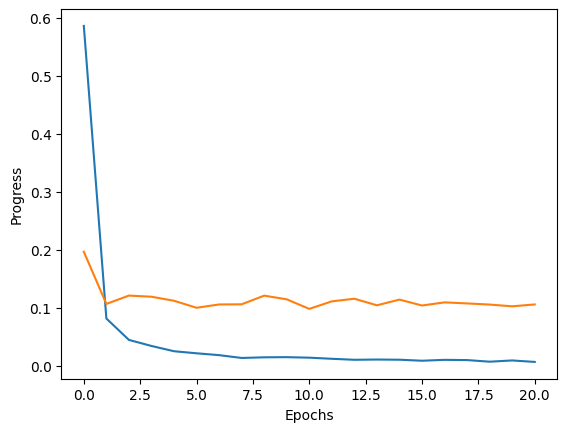

In [87]:
plot_losses(history)

In [88]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.0979 - mae: 0.0979 - mse: 0.0098


[0.0979120209813118, 0.0979120209813118, 0.009773524478077888]

In [89]:
preds = model.predict(X_test)

3/3 [==============================] - 0s 5ms/step


In [91]:
best = tf.keras.models.load_model('models/')
best.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.0979 - mae: 0.0979 - mse: 0.0098


[0.0979120209813118, 0.0979120209813118, 0.009773524478077888]

In [97]:
results = pd.DataFrame({"Actual": y_test,
                        "Preds": np.squeeze(preds, axis=-1)})
results

,Actual,Preds
0,-1.481800,-1.577701
1,-1.431732,-1.534352
2,-1.384070,-1.488685
3,-1.341558,-1.441743
4,-1.299312,-1.395297
...,...,...
71,1.479802,1.386877
72,1.524866,1.425623
73,1.570305,1.466443
74,1.610360,1.508756


<Axes: >

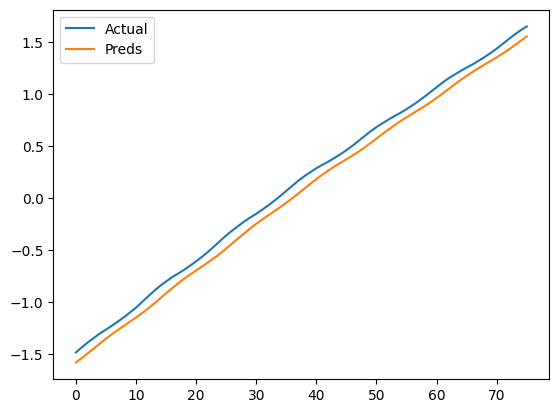

In [100]:
results.plot()

In [102]:
# Post-process predictions
results = (results * test_std) + test_mean
results.head()

,Actual,Preds
0,316806.125,316392.12500
1,317022.270,316579.25000
2,317228.026,316776.40625
3,317411.551,316979.03125
4,317593.923,317179.56250


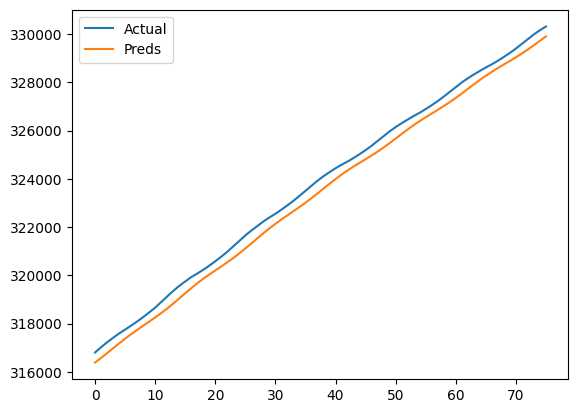

In [103]:
results.plot();

**[ Thank you ]**

# Time Series - **Hourly Energy Demand**

In [104]:
file = '/content/archive (20).zip'

ref = zipfile.ZipFile(file)
ref.extractall()
ref.close()

In [116]:
energy = pd.read_csv('energy_dataset.csv')
weather = pd.read_csv('weather_features.csv')

In [117]:
energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [121]:
# Make index column the time column
energy.index = pd.to_datetime(energy.time)
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [122]:
energy = energy.drop('time', axis=1)

In [123]:
energy.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [107]:
weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [124]:
weather.index = pd.to_datetime(weather.dt_iso)
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+01:00,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+01:00,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+01:00,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 04:00:00+01:00,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [125]:
weather = weather.drop('dt_iso', axis=1)
weather.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [199]:
load_forecasts = energy['total load forecast']
price_forecasts = energy['price day ahead']

We are going to try to model the `price actual` columns as a function of the following values from the master dataframe:

* `temp`
* `pressure`
* `humidity`
* `wind_spead`
* `wind_deg`

In [135]:
# create the new df for our values
data = pd.DataFrame({'temp': weather['temp'],
                     'pressure': weather['pressure'],
                     'humidity': weather['humidity'],
                     'wind_speed': weather['wind_speed'],
                     'wind_deg': weather['wind_deg']})
data.head()

,temp,pressure,humidity,wind_speed,wind_deg
dt_iso,,,,,
2015-01-01 00:00:00+01:00,270.475,1001,77,1,62
2015-01-01 01:00:00+01:00,270.475,1001,77,1,62
2015-01-01 02:00:00+01:00,269.686,1002,78,0,23
2015-01-01 03:00:00+01:00,269.686,1002,78,0,23
2015-01-01 04:00:00+01:00,269.686,1002,78,0,23


In [137]:
master = data.join(energy['price actual'])

In [139]:
master.head(12)

,temp,pressure,humidity,wind_speed,wind_deg,price actual
2015-01-01 00:00:00+01:00,270.475000,1001,77,1,62,65.41
2015-01-01 00:00:00+01:00,267.325000,971,63,1,309,65.41
2015-01-01 00:00:00+01:00,269.657312,1036,97,0,226,65.41
2015-01-01 00:00:00+01:00,281.625000,1035,100,7,58,65.41
2015-01-01 00:00:00+01:00,273.375000,1039,75,1,21,65.41
2015-01-01 01:00:00+01:00,270.475000,1001,77,1,62,64.92
2015-01-01 01:00:00+01:00,267.325000,971,63,1,309,64.92
2015-01-01 01:00:00+01:00,269.763500,1035,97,0,229,64.92
2015-01-01 01:00:00+01:00,281.625000,1035,100,7,58,64.92
2015-01-01 01:00:00+01:00,273.375000,1039,75,1,21,64.92


In [140]:
final = master[0::5]
final.head(12)

,temp,pressure,humidity,wind_speed,wind_deg,price actual
2015-01-01 00:00:00+01:00,270.475,1001,77,1,62,65.41
2015-01-01 01:00:00+01:00,270.475,1001,77,1,62,64.92
2015-01-01 02:00:00+01:00,269.686,1002,78,0,23,64.48
2015-01-01 03:00:00+01:00,269.686,1002,78,0,23,59.32
2015-01-01 04:00:00+01:00,269.686,1002,78,0,23,56.04
2015-01-01 05:00:00+01:00,270.292,1004,71,2,321,53.63
2015-01-01 06:00:00+01:00,270.292,1004,71,2,321,51.73
2015-01-01 07:00:00+01:00,270.292,1004,71,2,321,51.43
2015-01-01 08:00:00+01:00,274.601,1005,71,1,307,48.98
2015-01-01 09:00:00+01:00,274.601,1005,71,1,307,54.20


Our values are now all in one place and recorded on the hour. We can move forward with preprocessing and labelling of our multivariate data.

In [143]:
# Standardization function
def standardize(data):
  mean = data.mean()
  std = data.std()
  data = (data - mean) / std
  return data, mean, std

In [149]:
columns = [col for col in final.columns]
columns

['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'price actual']

In [150]:
t_standard, t_mean, t_std = standardize(final.temp)
p_standard, p_mean, p_std = standardize(final.pressure)
h_standard, h_mean, h_std = standardize(final.humidity)
ws_standard, ws_mean, ws_std = standardize(final.wind_speed)
wd_standard, wd_mean, wd_std = standardize(final.wind_deg)
price_standard, price_mean, price_std = standardize(final['price actual'])

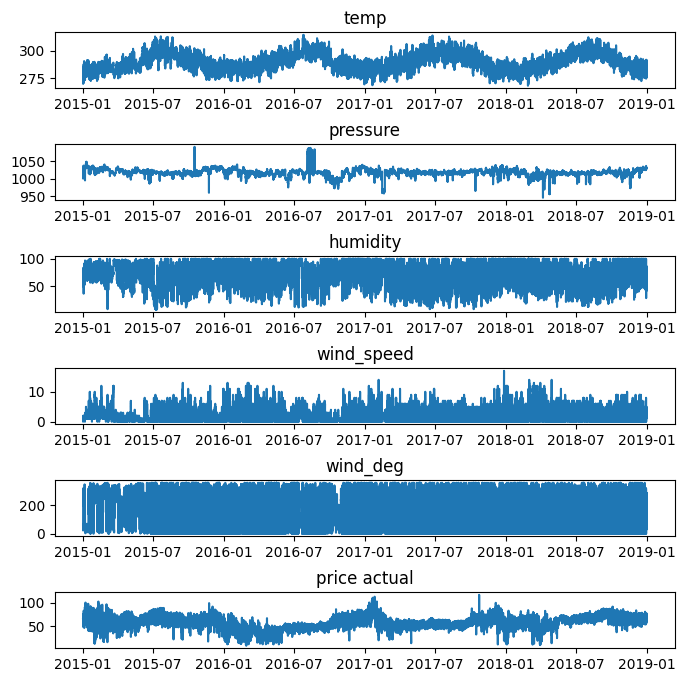

In [147]:
fig, axs = plt.subplots(nrows=final.shape[1], figsize=(8, 8))

# plot each column in a separate subplot
for i, col in enumerate(final.columns):
    axs[i].plot(final.index, final[col])
    axs[i].set_title(col)

# adjust spacing between subplots
plt.subplots_adjust(hspace=1.0)

# display the plot
plt.show()

In [152]:
standard_df = pd.DataFrame({'temp': t_standard,
                           'pressure': p_standard,
                           'humidity': h_standard,
                           'wind_speed': ws_standard,
                           'wind_deg': wd_standard,
                           'price': price_standard})
standard_df

,temp,pressure,humidity,wind_speed,wind_deg,price
2015-01-01 00:00:00+01:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.526959
2015-01-01 01:00:00+01:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.492468
2015-01-01 02:00:00+01:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.461496
2015-01-01 03:00:00+01:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.098284
2015-01-01 04:00:00+01:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,-0.132594
...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,-0.196677,0.899363,-0.770342,0.331521,-1.174364,1.344186
2018-12-31 20:00:00+01:00,-0.451177,0.986589,-0.388855,0.331521,-1.174364,1.283650
2018-12-31 21:00:00+01:00,-0.528799,0.899363,-0.579598,0.836696,-1.004194,1.152725
2018-12-31 22:00:00+01:00,-0.656049,0.986589,-0.627284,0.836696,-0.919109,0.842306


Much better.

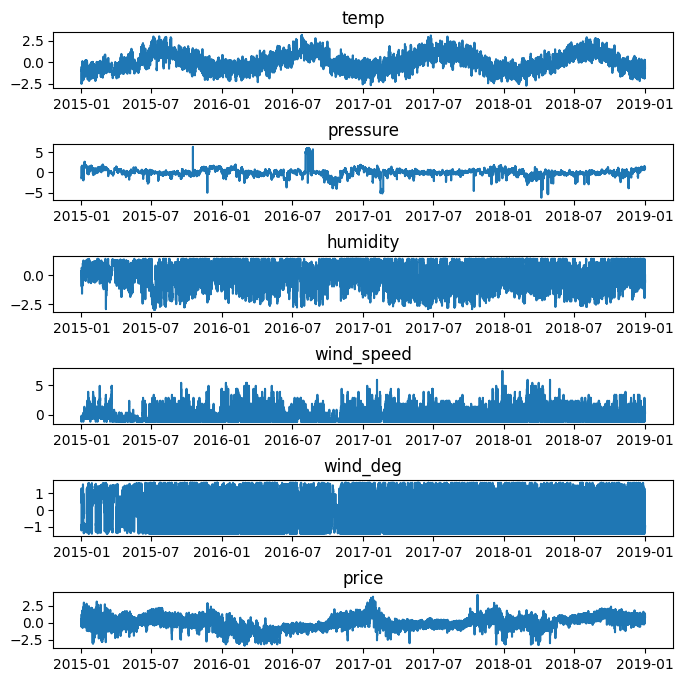

In [153]:
fig, axs = plt.subplots(nrows=standard_df.shape[1], figsize=(8, 8))

# plot each column in a separate subplot
for i, col in enumerate(standard_df.columns):
    axs[i].plot(standard_df.index, standard_df[col])
    axs[i].set_title(col)

# adjust spacing between subplots
plt.subplots_adjust(hspace=1.0)

# display the plot
plt.show()

In [168]:
standard_df.index = pd.to_datetime(standard_df.index, format='%Y/%m/%d %H:%M:%S', utc=True)

In [169]:
standard_df

,temp,pressure,humidity,wind_speed,wind_deg,price
2014-12-31 23:00:00+00:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.526959
2015-01-01 00:00:00+00:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.492468
2015-01-01 01:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.461496
2015-01-01 02:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.098284
2015-01-01 03:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,-0.132594
...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-0.196677,0.899363,-0.770342,0.331521,-1.174364,1.344186
2018-12-31 19:00:00+00:00,-0.451177,0.986589,-0.388855,0.331521,-1.174364,1.283650
2018-12-31 20:00:00+00:00,-0.528799,0.899363,-0.579598,0.836696,-1.004194,1.152725
2018-12-31 21:00:00+00:00,-0.656049,0.986589,-0.627284,0.836696,-0.919109,0.842306


In [170]:
standard_df = standard_df[1:]
standard_df

,temp,pressure,humidity,wind_speed,wind_deg,price
2015-01-01 00:00:00+00:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.492468
2015-01-01 01:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.461496
2015-01-01 02:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.098284
2015-01-01 03:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,-0.132594
2015-01-01 04:00:00+00:00,-2.419477,-1.194064,0.040319,-0.173654,1.301616,-0.302234
...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-0.196677,0.899363,-0.770342,0.331521,-1.174364,1.344186
2018-12-31 19:00:00+00:00,-0.451177,0.986589,-0.388855,0.331521,-1.174364,1.283650
2018-12-31 20:00:00+00:00,-0.528799,0.899363,-0.579598,0.836696,-1.004194,1.152725
2018-12-31 21:00:00+00:00,-0.656049,0.986589,-0.627284,0.836696,-0.919109,0.842306


In [171]:
standard_df['seconds'] = standard_df.index.map(pd.Timestamp.timestamp)

<ipython-input-171-2001515e2a14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df['seconds'] = standard_df.index.map(pd.Timestamp.timestamp)


In [172]:
standard_df

,temp,pressure,humidity,wind_speed,wind_deg,price,seconds
2015-01-01 00:00:00+00:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.492468,1.420070e+09
2015-01-01 01:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.461496,1.420074e+09
2015-01-01 02:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.098284,1.420078e+09
2015-01-01 03:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,-0.132594,1.420081e+09
2015-01-01 04:00:00+00:00,-2.419477,-1.194064,0.040319,-0.173654,1.301616,-0.302234,1.420085e+09
...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-0.196677,0.899363,-0.770342,0.331521,-1.174364,1.344186,1.546279e+09
2018-12-31 19:00:00+00:00,-0.451177,0.986589,-0.388855,0.331521,-1.174364,1.283650,1.546283e+09
2018-12-31 20:00:00+00:00,-0.528799,0.899363,-0.579598,0.836696,-1.004194,1.152725,1.546286e+09
2018-12-31 21:00:00+00:00,-0.656049,0.986589,-0.627284,0.836696,-0.919109,0.842306,1.546290e+09


In [173]:
day = 60 * 60 * 24
year = day * 365.2425

standard_df['day temp sin'] = np.sin(standard_df['seconds'] * (2 * np.pi / day))
standard_df['day temp cos'] = np.cos(standard_df['seconds'] * (2 * np.pi / day))
standard_df['year temp sin'] = np.sin(standard_df['seconds'] * (2 * np.pi / year))
standard_df['year temp cos'] = np.cos(standard_df['seconds'] * (2 * np.pi / year))

<ipython-input-173-065025a15447>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df['day temp sin'] = np.sin(standard_df['seconds'] * (2 * np.pi / day))
<ipython-input-173-065025a15447>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df['day temp cos'] = np.cos(standard_df['seconds'] * (2 * np.pi / day))
<ipython-input-173-065025a15447>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [174]:
standard_df

,temp,pressure,humidity,wind_speed,wind_deg,price,seconds,day temp sin,day temp cos,year temp sin,year temp cos
2015-01-01 00:00:00+00:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.492468,1.420070e+09,1.232357e-12,1.000000e+00,0.001505,0.999999
2015-01-01 01:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.461496,1.420074e+09,2.588190e-01,9.659258e-01,0.002222,0.999998
2015-01-01 02:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.098284,1.420078e+09,5.000000e-01,8.660254e-01,0.002939,0.999996
2015-01-01 03:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,-0.132594,1.420081e+09,7.071068e-01,7.071068e-01,0.003656,0.999993
2015-01-01 04:00:00+00:00,-2.419477,-1.194064,0.040319,-0.173654,1.301616,-0.302234,1.420085e+09,8.660254e-01,5.000000e-01,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-0.196677,0.899363,-0.770342,0.331521,-1.174364,1.344186,1.546279e+09,-1.000000e+00,-2.466750e-12,-0.002279,0.999997
2018-12-31 19:00:00+00:00,-0.451177,0.986589,-0.388855,0.331521,-1.174364,1.283650,1.546283e+09,-9.659258e-01,2.588190e-01,-0.001563,0.999999
2018-12-31 20:00:00+00:00,-0.528799,0.899363,-0.579598,0.836696,-1.004194,1.152725,1.546286e+09,-8.660254e-01,5.000000e-01,-0.000846,1.000000
2018-12-31 21:00:00+00:00,-0.656049,0.986589,-0.627284,0.836696,-0.919109,0.842306,1.546290e+09,-7.071068e-01,7.071068e-01,-0.000129,1.000000


We can drop the seconds column now.

In [175]:
standard_df = standard_df.drop('seconds', axis=1)
standard_df

,temp,pressure,humidity,wind_speed,wind_deg,price,day temp sin,day temp cos,year temp sin,year temp cos
2015-01-01 00:00:00+00:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.492468,1.232357e-12,1.000000e+00,0.001505,0.999999
2015-01-01 01:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.461496,2.588190e-01,9.659258e-01,0.002222,0.999998
2015-01-01 02:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.098284,5.000000e-01,8.660254e-01,0.002939,0.999996
2015-01-01 03:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,-0.132594,7.071068e-01,7.071068e-01,0.003656,0.999993
2015-01-01 04:00:00+00:00,-2.419477,-1.194064,0.040319,-0.173654,1.301616,-0.302234,8.660254e-01,5.000000e-01,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-0.196677,0.899363,-0.770342,0.331521,-1.174364,1.344186,-1.000000e+00,-2.466750e-12,-0.002279,0.999997
2018-12-31 19:00:00+00:00,-0.451177,0.986589,-0.388855,0.331521,-1.174364,1.283650,-9.659258e-01,2.588190e-01,-0.001563,0.999999
2018-12-31 20:00:00+00:00,-0.528799,0.899363,-0.579598,0.836696,-1.004194,1.152725,-8.660254e-01,5.000000e-01,-0.000846,1.000000
2018-12-31 21:00:00+00:00,-0.656049,0.986589,-0.627284,0.836696,-0.919109,0.842306,-7.071068e-01,7.071068e-01,-0.000129,1.000000


In [181]:
# Create windowed dataset
WINDOW = 24

def window(data, window=WINDOW):

  data = np.array(data)
  sequences = []
  labels = []

  for i in range(len(data) - window):
    row = [r for r in data[i:i + window]]
    sequences.append(row)
    label = data[i + window][5]
    labels.append(label)

  return np.array(sequences), np.array(labels)

In [182]:
sequences, labels = window(standard_df)

In [183]:
sequences[:5], labels[:5]

(array([[[-2.39619006e+00, -1.45574252e+00,  3.26435099e-01, ...,
           1.00000000e+00,  1.50524243e-03,  9.99998867e-01],
         [-2.49659015e+00, -1.36851639e+00,  3.74121076e-01, ...,
           9.65925826e-01,  2.22202354e-03,  9.99997531e-01],
         [-2.49659015e+00, -1.36851639e+00,  3.74121076e-01, ...,
           8.66025404e-01,  2.93880352e-03,  9.99995682e-01],
         ...,
         [-2.10147953e+00, -1.01961186e+00,  6.60236934e-01, ...,
           7.07106781e-01,  1.65569164e-02,  9.99862925e-01],
         [-2.30024372e+00, -1.01961186e+00,  5.64864981e-01, ...,
           8.66025404e-01,  1.72735962e-02,  9.99850800e-01],
         [-2.30024372e+00, -1.01961186e+00,  5.64864981e-01, ...,
           9.65925826e-01,  1.79902671e-02,  9.99838162e-01]],
 
        [[-2.49659015e+00, -1.36851639e+00,  3.74121076e-01, ...,
           9.65925826e-01,  2.22202354e-03,  9.99997531e-01],
         [-2.49659015e+00, -1.36851639e+00,  3.74121076e-01, ...,
           8.66025404

In [184]:
# Split into train and test
train_split = int(0.8*len(standard_df))
val_split = int(0.9*len(standard_df))

X_train = sequences[:train_split]
y_train = labels[:train_split]

X_val = sequences[train_split:val_split]
y_val = labels[train_split:val_split]

X_test = sequences[val_split:]
y_test = labels[val_split:]

In [185]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((28543, 24, 10), (28543,), (3568, 24, 10), (3568,), (3544, 24, 10), (3544,))

In [186]:
# Create model
multi = Sequential([
    layers.Input((24, 10)),
    layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(16, 'relu'),
    layers.Dense(1, 'linear')
], name='multi')

multi.compile(loss=losses.mae,
              optimizer='adam',
              metrics=['mae', 'mse'])

In [187]:
multi.fit(X_train, y_train, epochs=50,
          validation_data=(X_val, y_val))

Epoch 1/50
892/892 [==============================] - 5s 4ms/step - loss: 0.2290 - mae: 0.2290 - mse: 0.0979 - val_loss: 0.1559 - val_mae: 0.1559 - val_mse: 0.0415
Epoch 2/50
892/892 [==============================] - 4s 5ms/step - loss: 0.1551 - mae: 0.1551 - mse: 0.0449 - val_loss: 0.1104 - val_mae: 0.1104 - val_mse: 0.0241
Epoch 3/50
892/892 [==============================] - 3s 3ms/step - loss: 0.1412 - mae: 0.1412 - mse: 0.0382 - val_loss: 0.1272 - val_mae: 0.1272 - val_mse: 0.0293
Epoch 4/50
892/892 [==============================] - 3s 4ms/step - loss: 0.1350 - mae: 0.1350 - mse: 0.0356 - val_loss: 0.1099 - val_mae: 0.1099 - val_mse: 0.0237
Epoch 5/50
892/892 [==============================] - 3s 3ms/step - loss: 0.1335 - mae: 0.1335 - mse: 0.0348 - val_loss: 0.1159 - val_mae: 0.1159 - val_mse: 0.0243
Epoch 6/50
892/892 [==============================] - 4s 5ms/step - loss: 0.1318 - mae: 0.1318 - mse: 0.0341 - val_loss: 0.1196 - val_mae: 0.1196 - val_mse: 0.0252
Epoch 7/50
892/8

In [188]:
multi.evaluate(X_test, y_test)

111/111 [==============================] - 0s 2ms/step - loss: 0.1234 - mae: 0.1234 - mse: 0.0264


[0.12336894869804382, 0.12336894869804382, 0.026352837681770325]

In [190]:
lstm = Sequential([
    layers.Input((24, 10)),
    layers.LSTM(64, recurrent_dropout=0.05),
    layers.Dense(16),
    layers.Dense(8),
    layers.Dense(1, 'linear')
])

lstm.compile(loss=losses.mae,
              optimizer='adam',
              metrics=['mae', 'mse'])

early = callbacks.EarlyStopping(monitor='val_mae',
                                patience=3,
                                verbose=False,
                                restore_best_weights=True)

lstm.fit(X_train, y_train, epochs=50,
         validation_data=(X_val, y_val),
         callbacks=[early])

Epoch 1/50
892/892 [==============================] - 39s 40ms/step - loss: 0.2053 - mae: 0.2053 - mse: 0.0939 - val_loss: 0.1207 - val_mae: 0.1207 - val_mse: 0.0278
Epoch 2/50
892/892 [==============================] - 35s 39ms/step - loss: 0.1435 - mae: 0.1435 - mse: 0.0395 - val_loss: 0.1100 - val_mae: 0.1100 - val_mse: 0.0238
Epoch 3/50
892/892 [==============================] - 34s 38ms/step - loss: 0.1361 - mae: 0.1361 - mse: 0.0363 - val_loss: 0.1064 - val_mae: 0.1064 - val_mse: 0.0221
Epoch 4/50
892/892 [==============================] - 33s 37ms/step - loss: 0.1326 - mae: 0.1326 - mse: 0.0348 - val_loss: 0.1162 - val_mae: 0.1162 - val_mse: 0.0243
Epoch 5/50
892/892 [==============================] - 38s 43ms/step - loss: 0.1307 - mae: 0.1307 - mse: 0.0339 - val_loss: 0.1159 - val_mae: 0.1159 - val_mse: 0.0252
Epoch 6/50
892/892 [==============================] - 44s 49ms/step - loss: 0.1297 - mae: 0.1297 - mse: 0.0335 - val_loss: 0.1102 - val_mae: 0.1102 - val_mse: 0.0237


In [191]:
lstm.evaluate(X_test, y_test)

111/111 [==============================] - 1s 10ms/step - loss: 0.1250 - mae: 0.1250 - mse: 0.0297


[0.1250060349702835, 0.1250060349702835, 0.02967233769595623]

Conv1D model performed better.

In [201]:
# Plot preds
def plot_preds(model, test_features, test_labels, start=0, end=250):
  y_pred = model.predict(test_features)
  preds = (y_pred * price_std) + price_mean
  actuals = (test_labels * price_std) + price_mean

  plt.plot(actuals[start:end])
  plt.plot(preds[start:end])
  plt.xlabel("Time")
  plt.ylabel("Prices")
  plt.legend(["Actuals", "Predictions"])
  plt.show();

  return np.array(preds), np.array(actuals)

111/111 [==============================] - 0s 2ms/step


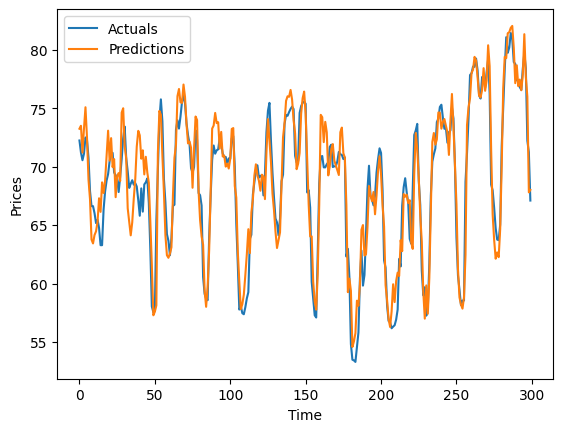

In [202]:
predictions, actuals = plot_preds(multi, X_test, y_test, start=0, end=300)

Let's check how we did compared to the `price day ahead` forecasts in the original dataframe.

In [209]:
price_forecasts = energy['price day ahead']
price_forecasts.index = pd.to_datetime(price_forecasts.index, format='%Y/%m/%d %H:%M:%S', utc=True)
price_forecasts[:12]

time
2014-12-31 23:00:00+00:00    50.10
2015-01-01 00:00:00+00:00    48.10
2015-01-01 01:00:00+00:00    47.33
2015-01-01 02:00:00+00:00    42.27
2015-01-01 03:00:00+00:00    38.41
2015-01-01 04:00:00+00:00    35.72
2015-01-01 05:00:00+00:00    35.13
2015-01-01 06:00:00+00:00    36.22
2015-01-01 07:00:00+00:00    32.40
2015-01-01 08:00:00+00:00    36.60
2015-01-01 09:00:00+00:00    43.10
2015-01-01 10:00:00+00:00    45.14
Name: price day ahead, dtype: float64

In [210]:
# Now columns will match - all data has been prepared the same way
price_forecasts = price_forecasts[1:]
price_forecasts

time
2015-01-01 00:00:00+00:00    48.10
2015-01-01 01:00:00+00:00    47.33
2015-01-01 02:00:00+00:00    42.27
2015-01-01 03:00:00+00:00    38.41
2015-01-01 04:00:00+00:00    35.72
                             ...  
2018-12-31 18:00:00+00:00    68.85
2018-12-31 19:00:00+00:00    68.40
2018-12-31 20:00:00+00:00    66.88
2018-12-31 21:00:00+00:00    63.93
2018-12-31 22:00:00+00:00    64.27
Name: price day ahead, Length: 35063, dtype: float64

In [211]:
standard_df

,temp,pressure,humidity,wind_speed,wind_deg,price,day temp sin,day temp cos,year temp sin,year temp cos
2015-01-01 00:00:00+00:00,-2.396190,-1.455743,0.326435,-0.678829,-0.902091,0.492468,1.232357e-12,1.000000e+00,0.001505,0.999999
2015-01-01 01:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.461496,2.588190e-01,9.659258e-01,0.002222,0.999998
2015-01-01 02:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,0.098284,5.000000e-01,8.660254e-01,0.002939,0.999996
2015-01-01 03:00:00+00:00,-2.496590,-1.368516,0.374121,-1.184004,-1.233924,-0.132594,7.071068e-01,7.071068e-01,0.003656,0.999993
2015-01-01 04:00:00+00:00,-2.419477,-1.194064,0.040319,-0.173654,1.301616,-0.302234,8.660254e-01,5.000000e-01,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-0.196677,0.899363,-0.770342,0.331521,-1.174364,1.344186,-1.000000e+00,-2.466750e-12,-0.002279,0.999997
2018-12-31 19:00:00+00:00,-0.451177,0.986589,-0.388855,0.331521,-1.174364,1.283650,-9.659258e-01,2.588190e-01,-0.001563,0.999999
2018-12-31 20:00:00+00:00,-0.528799,0.899363,-0.579598,0.836696,-1.004194,1.152725,-8.660254e-01,5.000000e-01,-0.000846,1.000000
2018-12-31 21:00:00+00:00,-0.656049,0.986589,-0.627284,0.836696,-0.919109,0.842306,-7.071068e-01,7.071068e-01,-0.000129,1.000000


In [213]:
len(price_forecasts), len(predictions), len(actuals) # only need the last values from val_split on

(35063, 3544, 3544)

In [218]:
preds_df = pd.DataFrame({'Provided Forecasts': price_forecasts[-3544:],
                         'Predicted Values': np.squeeze(predictions, axis=-1),
                         'Actual Values': actuals})

In [219]:
preds_df

,Provided Forecasts,Predicted Values,Actual Values
time,,,
2018-08-06 07:00:00+00:00,64.60,73.246254,72.24
2018-08-06 08:00:00+00:00,64.67,73.499069,71.21
2018-08-06 09:00:00+00:00,64.60,71.201271,70.55
2018-08-06 10:00:00+00:00,64.60,73.251396,71.11
2018-08-06 11:00:00+00:00,63.50,75.084427,72.50
...,...,...,...
2018-12-31 18:00:00+00:00,68.85,79.397446,77.02
2018-12-31 19:00:00+00:00,68.40,77.103088,76.16
2018-12-31 20:00:00+00:00,66.88,75.944099,74.30


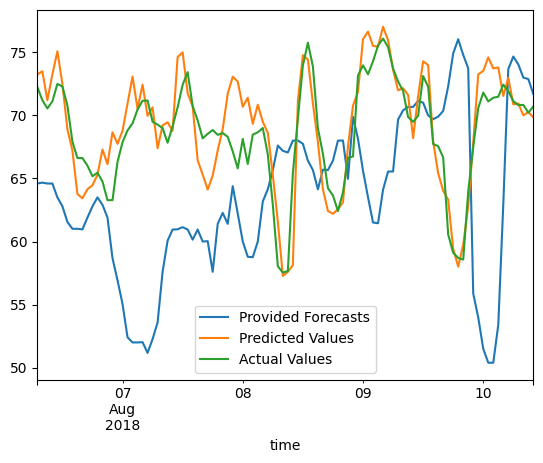

In [222]:
preds_df[:100].plot();

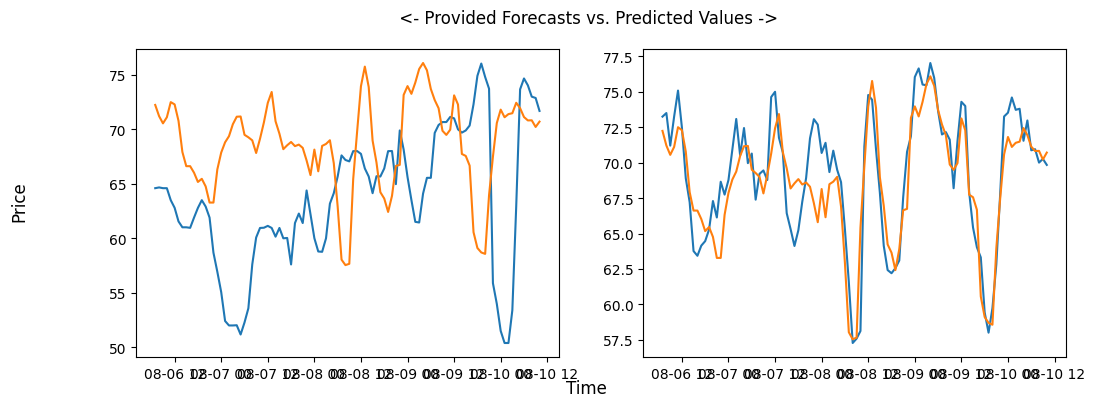

In [230]:
# Cleaning things up a litte
START = 0
END = 100

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(preds_df['Provided Forecasts'][START:END])
axs[0].plot(preds_df['Actual Values'][START:END])

axs[1].plot(preds_df['Predicted Values'][START:END])
axs[1].plot(preds_df['Actual Values'][START:END])

fig.suptitle(' <- Provided Forecasts vs. Predicted Values ->')
fig.supxlabel("Time")
fig.supylabel("Price")
fig.show();

We've greatly outperformed the provided forecasts on the energy price by training a model to predict prices as a function of **temperature, pressure, humidity, wind speed, past price data, and day/year sine and cosine signals**.

# **[ Thank you ]**